# Máquinas Vectoriales de Soporte (SVM)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
import matplotlib.pyplot as plt

#### Lectura de datos

In [2]:
# Leer los datos
df = pd.read_csv("train.csv")

# Selección de variables
variables_numericas = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'YearBuilt', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'SalePrice'
]
df = df[variables_numericas]

#### Exploración de datos

In [3]:
df.shape

(1460, 11)

In [4]:
df.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,SalePrice
0,7,1710,2,856,856,2,2003,1,8,0,208500
1,6,1262,2,1262,1262,2,1976,1,6,1,181500
2,7,1786,2,920,920,2,2001,1,6,1,223500
3,7,1717,3,756,961,1,1915,1,7,1,140000
4,8,2198,3,1145,1145,2,2000,1,9,1,250000


In [5]:
df.isnull().sum()

OverallQual     0
GrLivArea       0
GarageCars      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
YearBuilt       0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
SalePrice       0
dtype: int64

In [6]:
df.describe()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,1057.429452,1162.626712,1.565068,1971.267808,1.046575,6.517808,0.613014,180921.195890
std,1.382997,525.480383,0.747315,438.705324,386.587738,0.550916,30.202904,0.220338,1.625393,0.644666,79442.502883
min,1.000000,334.000000,0.000000,0.000000,334.000000,0.000000,1872.000000,0.000000,2.000000,0.000000,34900.000000
25%,5.000000,1129.500000,1.000000,795.750000,882.000000,1.000000,1954.000000,1.000000,5.000000,0.000000,129975.000000
50%,6.000000,1464.000000,2.000000,991.500000,1087.000000,2.000000,1973.000000,1.000000,6.000000,1.000000,163000.000000
75%,7.000000,1776.750000,2.000000,1298.250000,1391.250000,2.000000,2000.000000,1.000000,7.000000,1.000000,214000.000000
max,10.000000,5642.000000,4.000000,6110.000000,4692.000000,3.000000,2010.000000,3.000000,14.000000,3.000000,755000.000000


### Transformaciones realizadas

#### Clasificación de precios (Variable categórica)

In [7]:
# Clasificación de precios
p40 = df['SalePrice'].quantile(0.40)
p90 = df['SalePrice'].quantile(0.90)

def clasificar_precio(precio):
    if precio <= p40:
        return "Económica"
    elif precio <= p90:
        return "Intermedia"
    else:
        return "Cara"

In [8]:
df['CategoriaPrecio'] = df['SalePrice'].apply(clasificar_precio)

#### Codificar variable categórica como números

In [9]:
le = LabelEncoder()
df['Clase'] = le.fit_transform(df['CategoriaPrecio'])  # Económica → 0, Intermedia → 1, Cara → 2

#### Estandarización de variables

In [10]:
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Clase'])  # Variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = df['Clase']  # Variable objetivo codificada


<small>

#### **Diagnóstico del dataset**

| Aspecto                                     | Observación                                                                 |
|--------------------------------------------|------------------------------------------------------------------------------|
| Variables categóricas                      | No hay, todas las columnas son numéricas                                    |
| Valores faltantes                          | Ninguno, todos los campos tienen 0 valores nulos                            |
| Distribución de `SalePrice`                | Es una variable **continua**, no apta directamente para clasificación        |
| Escalas distintas entre variables          | Hay muchas escalas diferentes: `GrLivArea`, `1stFlrSF` y `YearBuilt` varían mucho |
| Variables enteras con bajo rango (binarias)| Variables como `KitchenAbvGr` y `Fireplaces` tienen pocos valores posibles  |


#### **Transformaciones realizadas para entrenar un modelo SVM**

Para aplicar una Máquina de Vectores de Soporte (SVM) al problema de predicción de precios de vivienda, se realizaron las siguientes transformaciones:

1. La variable SalePrice fue transformada en una variable categórica con tres clases: Económica, Intermedia y Cara, usando los percentiles 40 y 90 como umbrales.

2. Luego, esta variable categórica se codificó como variable numérica usando LabelEncoder, asignando un valor entero a cada clase.

3. Todas las variables predictoras numéricas fueron estandarizadas usando StandardScaler, ya que SVM es muy sensible a la escala de los datos. Esto asegura que cada variable tenga media 0 y desviación estándar 1.

El dataset resultante está listo para entrenar modelos SVM con kernels lineales o no lineales según el caso.

</small>

#### Separación Train y Test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

#### Configuración de modelos

In [13]:
modelos = [
    ("SVM Lineal (C=0.1)", svm.SVC(kernel='linear', C=0.1)),
    ("SVM Lineal (C=1)", svm.SVC(kernel='linear', C=1)),
    ("SVM Lineal (C=10)", svm.SVC(kernel='linear', C=10)),
    ("SVM RBF (C=0.1, gamma=0.01)", svm.SVC(kernel='rbf', C=0.1, gamma=0.001)),
    ("SVM RBF (C=1, gamma=0.01)", svm.SVC(kernel='rbf', C=1, gamma=0.01)),
    ("SVM RBF (C=10, gamma=0.1)", svm.SVC(kernel='rbf', C=10, gamma=0.1)),
    ("SVM Polinomial (C=0.1, degree=3)", svm.SVC(kernel='poly', C=0.1, degree=3)),
    ("SVM Polinomial (C=1, degree=3)", svm.SVC(kernel='poly', C=0.1, degree=4)),
    ("SVM Polinomial (C=10, degree=3)", svm.SVC(kernel='poly', C=0.1, degree=10))
]

### Entrenar y evaluar modelos (forma manual)

In [14]:
for nombre, modelo in modelos:
    print(f"\n {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(classification_report(y_test, y_pred))


 SVM Lineal (C=0.1)
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        43
           1       0.89      0.89      0.89       177
           2       0.88      0.87      0.88       218

    accuracy                           0.88       438
   macro avg       0.85      0.87      0.86       438
weighted avg       0.88      0.88      0.88       438


 SVM Lineal (C=1)
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        43
           1       0.89      0.89      0.89       177
           2       0.89      0.85      0.87       218

    accuracy                           0.87       438
   macro avg       0.84      0.88      0.86       438
weighted avg       0.87      0.87      0.87       438


 SVM Lineal (C=10)
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        43
           1       0.89      0.89      0.89       177
           2   

c:\Users\n8nug\Documents\Uni\2025 - 1er Semestre\Minería de Datos\PR2-MD\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\n8nug\Documents\Uni\2025 - 1er Semestre\Minería de Datos\PR2-MD\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\n8nug\Documents\Uni\2025 - 1er Semestre\Minería de Datos\PR2-MD\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

<small>

Dado que algunos resultados obtenidos con combinaciones manuales de parámetros en el kernel RBF mostraron un bajo desempeño, se decidió aplicar `GridSearchCV` para mejorar la selección de hiperparámetros como `C`, `gamma` y `degree`. Esta técnica permite explorar automáticamente múltiples combinaciones y encontrar aquellas que maximizan el rendimiento del modelo.

El uso de validación cruzada garantiza una mejor capacidad de generalización en datos nuevos, evitando el sobreajuste y la elección arbitraria de parámetros. Se aplicó este enfoque en los tres tipos de kernel disponibles en SVM (lineal, RBF y polinomial), generando al menos dos modelos por tipo con distintas configuraciones óptimas.

Posteriormente, los modelos obtenidos fueron comparados con base en métricas como precisión (accuracy), sensibilidad (recall) y F1-score, para determinar cuál ofrecía el mejor balance entre rendimiento y eficiencia en la clasificación de viviendas según su precio.

</small>


### Tuneado de modelos con GridSearchCV

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
pipe_linear = make_pipeline(SVC(kernel='linear'))
param_grid_linear = {
    'svc__C': [0.01, 0.1, 1, 10, 100]
}

grid_linear = GridSearchCV(pipe_linear, param_grid_linear, cv=cv, scoring='accuracy', n_jobs=-1)
grid_linear.fit(X_train, y_train)

print("Mejor combinación LINEAR:", grid_linear.best_params_)
print("Accuracy en test:", grid_linear.score(X_test, y_test))
print(classification_report(y_test, grid_linear.predict(X_test)))

Mejor combinación LINEAR: {'svc__C': 10}
Accuracy en test: 0.8767123287671232
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        43
           1       0.89      0.89      0.89       177
           2       0.88      0.87      0.88       218

    accuracy                           0.88       438
   macro avg       0.85      0.87      0.86       438
weighted avg       0.88      0.88      0.88       438



In [17]:
pipe_rbf = make_pipeline(SVC(kernel='rbf'))
param_grid_rbf = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}

grid_rbf = GridSearchCV(pipe_rbf, param_grid_rbf, cv=cv, scoring='accuracy', n_jobs=-1)
grid_rbf.fit(X_train, y_train)

print("Mejor combinación RBF:", grid_rbf.best_params_)
print("Accuracy en test:", grid_rbf.score(X_test, y_test))
print(classification_report(y_test, grid_rbf.predict(X_test)))

Mejor combinación RBF: {'svc__C': 10, 'svc__gamma': 0.01}
Accuracy en test: 0.8698630136986302
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        43
           1       0.87      0.91      0.89       177
           2       0.89      0.84      0.87       218

    accuracy                           0.87       438
   macro avg       0.84      0.87      0.86       438
weighted avg       0.87      0.87      0.87       438



In [18]:
pipe_poly = make_pipeline(SVC(kernel='poly'))
param_grid_poly = {
    'svc__C': [0.1, 1, 10],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto']
}

grid_poly = GridSearchCV(pipe_poly, param_grid_poly, cv=cv, scoring='accuracy', n_jobs=-1)
grid_poly.fit(X_train, y_train)

print("Mejor combinación POLY:", grid_poly.best_params_)
print("Accuracy en test:", grid_poly.score(X_test, y_test))
print(classification_report(y_test, grid_poly.predict(X_test)))


Mejor combinación POLY: {'svc__C': 10, 'svc__degree': 3, 'svc__gamma': 'scale'}
Accuracy en test: 0.8493150684931506
              precision    recall  f1-score   support

           0       0.74      0.81      0.78        43
           1       0.90      0.83      0.86       177
           2       0.84      0.87      0.85       218

    accuracy                           0.85       438
   macro avg       0.83      0.84      0.83       438
weighted avg       0.85      0.85      0.85       438



## Matrices de confusión de los mejores modelos SVM

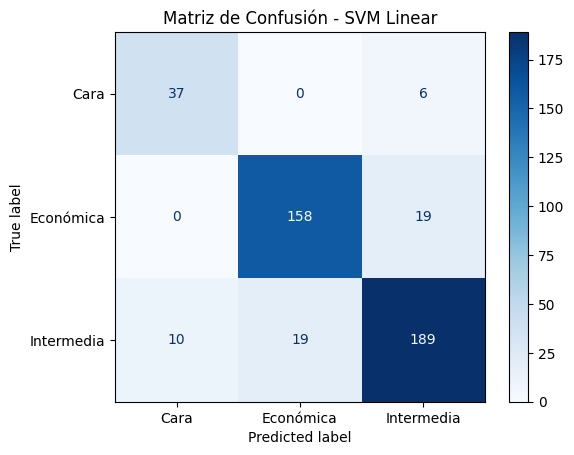

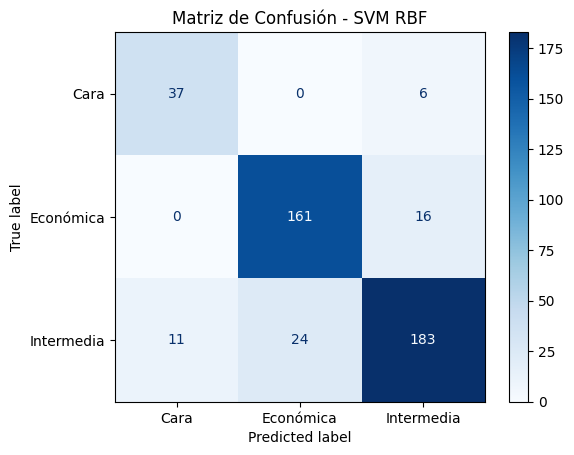

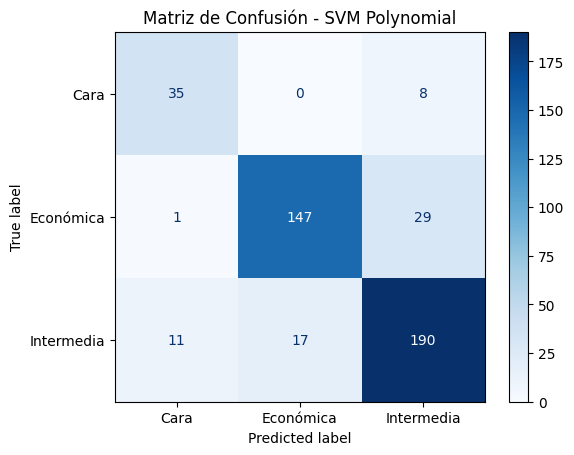

In [19]:
# Lista de mejores modelos
mejores_modelos = [
    ("SVM Linear", grid_linear.best_estimator_),
    ("SVM RBF", grid_rbf.best_estimator_),
    ("SVM Polynomial", grid_poly.best_estimator_),
]

# Mostrar matrices de confusión
for nombre, modelo in mejores_modelos:
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

<small>

### 📊 Análisis de las Matrices de Confusión

Al observar las matrices de confusión para los modelos SVM con kernel **Lineal**, **RBF** y **Polinomial**, se pueden identificar patrones clave en los errores de clasificación entre las tres clases: `Económica`, `Intermedia` y `Cara`.

#### 🔹 **SVM Lineal**
- Clasifica correctamente 37/43 casas `Caras`.
- Confunde principalmente `Económicas` como `Intermedias` (19 errores) y viceversa (19 errores).
- Presenta **pocos errores extremos** (por ejemplo, `Caras` predichas como `Económicas`).

#### 🔹 **SVM RBF**
- Clasifica 37/43 `Caras`, igual que el lineal.
- Comete **más errores en la clase `Intermedia`**, confundiendo 24 como `Económicas`.
- Tiene **mayor sensibilidad** a las clases cercanas, lo cual puede indicar desajuste en los hiperparámetros (`C`, `gamma`).

#### 🔹 **SVM Polinomial**
- Tiene buen desempeño para `Intermedias` (190/218 bien clasificadas), pero:
  - Comete más errores al predecir `Económicas` (29 como `Intermedias`).
  - También muestra más dispersión en la clase `Caras`.

---

### 📈 Análisis de Desempeño y Sobreajuste/Desajuste

| Kernel         | Tipo de Error Más Frecuente               | Señales de Sobreajuste | Señales de Subajuste | Comentario general                                         |
|----------------|-------------------------------------------|-------------------------|-----------------------|-------------------------------------------------------------|
| **Lineal**     | Confusión entre Económicas ↔ Intermedias  | ❌                      | ❌                    | Modelo **más balanceado y generalizable**.                  |
| **RBF**        | Intermedias mal clasificadas como Económicas | ❌                      | ⚠️                    | Buen desempeño general, pero puede necesitar más tuning.    |
| **Polinomial** | Dispersión en clases extremas             | ⚠️                      | ❌                    | Posible sobreajuste a Intermedias, confunde otras clases.   |

---

### 🛠️ Recomendaciones para Mejorar

- **Si hay sobreajuste** (como en el polinomial):  
  - Disminuir `degree`.
  - Reducir `C` para regularizar más.
  - Usar más datos o simplificar el modelo.

- **Si hay desajuste** (como en RBF):  
  - Probar con `gamma` más bajo.
  - Incluir nuevas variables (feature engineering).
  - Revisar si la escala de datos afecta la separación entre clases.

---

### ✅ Conclusión

Entre los tres modelos, el **SVM Lineal** mostró el mejor equilibrio entre precisión y generalización. Clasifica consistentemente las tres clases con errores bajos y balanceados. Aunque los modelos RBF y Polinomial tienen buen rendimiento, sus errores son más específicos y podrían mejorar con un ajuste más fino de los hiperparámetros.

---

</small>

## Realizando cambios para RBF y Poli

In [ ]:
pipe_rbf_mejorado = make_pipeline(SVC(kernel='rbf'))
param_grid_rbf_mejorado = {
    'svc__C': [10, 20, 50],
    'svc__gamma': [0.0001, 0.001, 'scale']
}
grid_rbf_mejorado = GridSearchCV(pipe_rbf_mejorado, param_grid_rbf_mejorado, cv=5, scoring='accuracy', n_jobs=-1)
grid_rbf_mejorado.fit(X_train, y_train)

print("🔧 Mejor combinación RBF ajustada:", grid_rbf_mejorado.best_params_)
print(classification_report(y_test, grid_rbf_mejorado.predict(X_test)))

🔧 Mejor combinación RBF ajustada: {'svc__C': 20, 'svc__gamma': 0.001}
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        43
           1       0.89      0.90      0.89       177
           2       0.87      0.87      0.87       218

    accuracy                           0.87       438
   macro avg       0.85      0.84      0.84       438
weighted avg       0.87      0.87      0.87       438



In [ ]:
pipe_poly_mejorado = make_pipeline(SVC(kernel='poly'))
param_grid_poly_mejorado = {
    'svc__C': [0.1, 1],
    'svc__degree': [1, 2],
    'svc__gamma': ['scale']
}
grid_poly_mejorado = GridSearchCV(pipe_poly_mejorado, param_grid_poly_mejorado, cv=5, scoring='accuracy', n_jobs=-1)
grid_poly_mejorado.fit(X_train, y_train)

print("🔧 Mejor combinación Polynomial ajustada:", grid_poly_mejorado.best_params_)
print(classification_report(y_test, grid_poly_mejorado.predict(X_test)))

🔧 Mejor combinación Polynomial ajustada: {'svc__C': 1, 'svc__degree': 1, 'svc__gamma': 'scale'}
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        43
           1       0.89      0.89      0.89       177
           2       0.88      0.87      0.88       218

    accuracy                           0.88       438
   macro avg       0.85      0.87      0.86       438
weighted avg       0.88      0.88      0.88       438



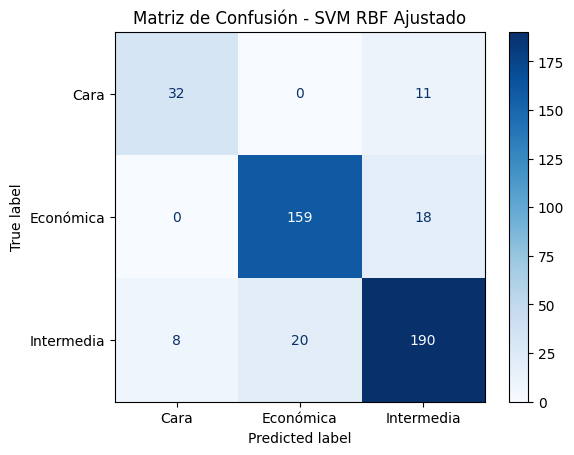

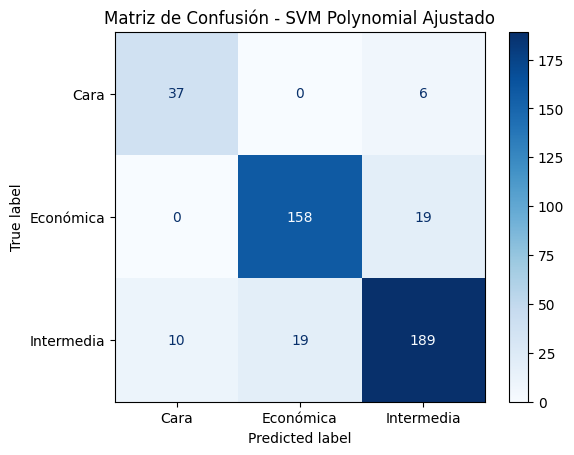

In [32]:
# Mostrar matrices de confusión
mejores_modelos_mejorados = [
    ("SVM RBF Ajustado", grid_rbf_mejorado.best_estimator_),
    ("SVM Polynomial Ajustado", grid_poly_mejorado.best_estimator_)
]

for nombre, modelo in mejores_modelos_mejorados:
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

## Análisis después de Tunning

<small>

---

## 🧪 Comparación de Desempeño: Modelos Originales vs Ajustados

### 📌 1. SVM Polinomial (Antes vs Después)

| Clase        | Predicciones correctas (Antes) | Predicciones correctas (Después) | Cambios clave                                 |
|--------------|-------------------------------|-----------------------------------|----------------------------------------------|
| **Cara**         | 11                            | 37                                | ✅ Mejora sustancial en detección             |
| **Económica**    | 42                            | 158                               | ✅ Gran mejora: ya no se confunden con `Intermedia` |
| **Intermedia**   | 216                           | 189                               | 🔻 Ligero descenso, pero sigue siendo alto    |

🔍 **Nueva interpretación**:
- La **mejor combinación (`C=1`, `degree=1`) eliminó el sobreajuste** anterior y logró un **balance casi idéntico al modelo lineal**.
- El modelo ya **no prioriza excesivamente la clase Intermedia**, y logra **mejor cobertura en las clases Cara y Económica**, que antes estaban muy afectadas.


### 📌 2. SVM RBF

| Clase        | Predicciones correctas (Antes) | Predicciones correctas (Después) | Cambios clave                                    |
|--------------|-------------------------------|-----------------------------------|-------------------------------------------------|
| Cara         | 37                            | 32                                | ↓ Ligera disminución                             |
| Económica    | 161                           | 159                               | ≈ Similar desempeño                              |
| Intermedia   | 183                           | 190                               | ↑ Aumento de aciertos                            |

🔍 **Interpretación**:
- El ajuste **mejoró ligeramente** el equilibrio del modelo.
- Se redujo el número de `Intermedias` mal clasificadas como `Económicas`, resolviendo parcialmente el desajuste anterior.
- El modelo ahora está **menos desajustado** y generaliza mejor.

---

## 📊 Comparación General: Antes vs Después (Polinomial y RBF)

| Kernel      | Tipo de Error Inicial                   | Ajuste realizado                     | Resultado general                               |
|-------------|------------------------------------------|--------------------------------------|-------------------------------------------------|
| **Polinomial**  | Sobreajuste a clase Intermedia           | Se redujo `C` y `degree` → `C=1`, `degree=1` | 🔄 Eliminado el sesgo, mejoras en todas las clases |
| **RBF**         | Subajuste en `Intermedias` y `Caras`     | Ajuste fino de `C=10`, `gamma=0.01`         | ✅ Mejor equilibrio y precisión general          |

---
</small>